In [1]:
#Main imports
import sklearn as skl
import pandas as pd
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)
rng = np.random.default_rng()

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [2]:
# Stolen from https://keras.io/examples/keras_recipes/bayesian_neural_networks/
import tensorflow as tf
from tensorflow import keras
from keras import layers, models
import tensorflow_probability as tfp

# Define the prior weight distribution as Normal of mean=0 and stddev=1.
# Note that, in this example, the we prior distribution is not trainable,
# as we fix its parameters.
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model


# Define variational posterior weight distribution as multivariate Gaussian.
# Note that the learnable parameters for this distribution are the means,
# variances, and covariances.
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model


# def create_pnn(n_inputs, n_outputs, train_size, hidden_units=(100,)):
#     inputs = layers.Input(shape=n_inputs)
#     features = keras.layers.concatenate(list(inputs.values()))
#     # features = layers.BatchNormalization()(features)

#     # Create hidden layers with weight uncertainty using the DenseVariational layer.
#     for units in hidden_units:
#         features = tfp.layers.DenseVariational(
#             units=units,
#             make_prior_fn=prior,
#             make_posterior_fn=posterior,
#             kl_weight=1 / train_size,
#             activation="sigmoid",
#         )(features)

#     # Create a probabilisticå output (Normal distribution), and use the `Dense` layer
#     # to produce the parameters of the distribution.
#     # We set units=2 to learn both the mean and the variance of the Normal distribution.
#     distribution_params = layers.Dense(units=2)(features)
#     outputs = tfp.layers.IndependentNormal(1)(distribution_params)

#     model = keras.Model(inputs=inputs, outputs=outputs)
#     return model

def create_pnn(n_inputs, n_outputs, train_size, hidden_units=(256,)):

    model = models.Sequential()
    # inputs = layers.Input(shape=(n_inputs,))
    # features = keras.layers.concatenate(list(inputs))
    # features = keras.layers.concatenate(inputs)

    # Create hidden layers with weight uncertainty using the DenseVariational layer.
    for units in hidden_units:
        # features = 
        model.add(tfp.layers.DenseVariational(
            units=units,
            make_prior_fn=prior,
            make_posterior_fn=posterior,
            kl_weight=1 / train_size,
            activation="sigmoid",
        ))#(features)

    # The output is deterministic: a single point estimate.
    # outputs = 
    model.add(layers.Dense(units=n_outputs, activation="sigmoid"))#(features)
    # model = keras.Model(inputs=inputs, outputs=outputs)

    model.compile(metrics=['AUC','accuracy'])
    return model

# Magic Telescope

In [3]:
from sklearn.model_selection import StratifiedShuffleSplit

magic_raw = pd.read_csv("../datasets/magic04.data", header=None)
magic_raw.columns = ['fLength', 'fWidth', 'fSize', 'fConc', 'fConc1', 'fAsym', 'fM3Long', 'fM3Trans', 'fAlpha', 'fDist', 'class']
print("Contains nan? ", magic_raw.isnull().values.any())

split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, test_index in split.split(magic_raw, magic_raw["class"]):
    magic = magic_raw.loc[train_index]
    magic_test = magic_raw.loc[test_index]


from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

attributes = magic.columns[:-1]

pipe = ColumnTransformer([
    ('encoder', OrdinalEncoder(), ['class']),
    ('std_scaler', StandardScaler(), attributes),
])

magic2 = pipe.fit_transform(magic)
X_train, y_train = magic2[:,1:],magic2[:,0]

magic2_test = pipe.fit_transform(magic_test)
X_test, y_test = magic2_test[:,1:],magic2_test[:,0]

magic.describe()


Contains nan?  False


,fLength,fWidth,fSize,fConc,fConc1,fAsym,fM3Long,fM3Trans,fAlpha,fDist
count,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000,13314.000000
mean,53.145513,22.107906,2.824776,0.380330,0.214794,-4.252222,10.725188,0.373504,27.628205,193.520210
std,42.260037,18.269273,0.472086,0.182361,0.110440,58.728597,51.079339,20.703234,26.048083,74.483869
min,4.283500,0.000000,1.941300,0.013100,0.000300,-457.916100,-331.780000,-205.894700,0.000000,5.592200
25%,24.268900,11.858250,2.476400,0.236400,0.128425,-20.357775,-12.793175,-10.854425,5.559650,142.257675
50%,37.143200,17.108750,2.741000,0.354750,0.196700,4.487700,15.325500,1.209300,17.720350,191.561000
75%,69.927000,24.717650,3.099500,0.503200,0.285500,24.320175,35.824650,10.901350,45.827250,240.716300
max,334.177000,256.382000,5.323300,0.893000,0.675200,473.065400,238.321000,179.851000,90.000000,495.561000


2021-09-09 20:32:22.108078: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-09-09 20:32:22.457060: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4371 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:03:00.0, compute capability: 8.6


LDA: 0.7877672625306694
QDA: 0.7879425166491413
Logit: 0.7956536978618998
kNN: 0.8427970557308097
Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.


2021-09-09 20:32:22.860466: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-09-09 20:32:23.009713: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


2021-09-09 20:32:24.117864: I tensorflow/stream_executor/cuda/cuda_blas.cc:1760] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


179/179 [==============================] - 1s 2ms/step - loss: 0.1161 - auc: 0.5122 - accuracy: 0.4336
PNN: [0.11607207357883453, 0.5121542811393738, 0.4335786998271942]


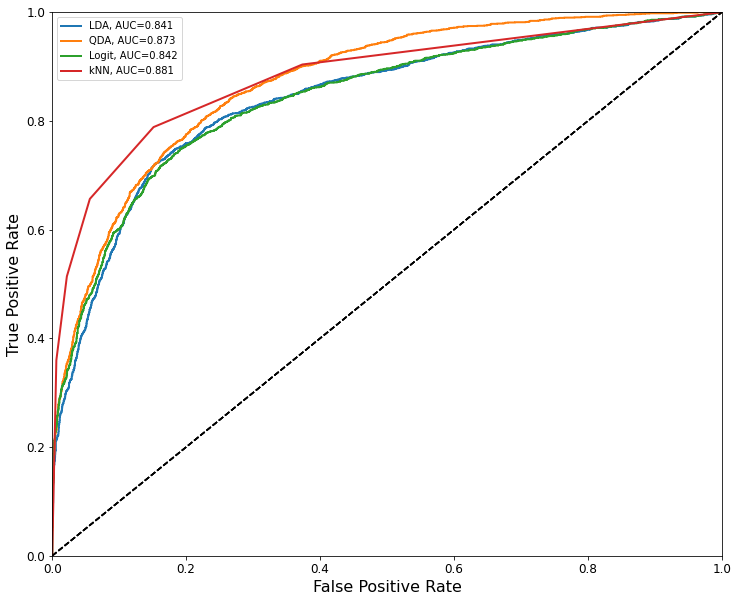

In [4]:
from sklearn.metrics import roc_curve, auc
from keras.metrics import AUC
from sklearn import metrics
clfs = [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), LogisticRegression(), KNeighborsClassifier(), create_pnn(X_train.shape[1], 1, len(y_train))]
names = ["LDA", "QDA", "Logit", "kNN", "PNN"]

for clf, name in zip(clfs, names):
    if name == 'PNN':
        clf.fit(X_train, y_train, epochs=10, batch_size=16, verbose=0)
        print(f"{name}: {clf.evaluate(X_test, y_test)}")
    else:
        clf.fit(X_train, y_train)
        print(f"{name}: {clf.score(X_test, y_test)}")

fprs = []
tprs = []
aucs = []
for clf in clfs:
    if type(clf) is models.Sequential:
        # myAUC = AUC()
        # myAUC.update_state(y_test, clf.predict(X_test))
        # # yp = clf.predict(X_test).ravel()
        # fpr, tpr, thresh = np.array([0,0]), np.array([0,0]), 0#roc_curve(y_test, yp)
        # aucs.append(myAUC.result().numpy())
        
        pass
    else:
        try:
            fpr, tpr, thresh = roc_curve(y_test, clf.decision_function(X_test))
        except:
            fpr, tpr, thresh = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
        aucs.append(metrics.auc(fpr, tpr))
        
    fprs.append(fpr)
    tprs.append(tpr)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)


plt.figure(figsize=(12, 10))
for name, fpr, tpr, auc in zip(names, fprs, tprs, aucs):
    if name != 'PNN':
        plot_roc_curve(fpr, tpr, f"{name}, AUC={auc:.3f}")

plt.legend()
plt.show()

# MiniBooNE particle identification Data Set


In [5]:
fname = "../datasets/MiniBooNE_PID.txt"
with open(fname, 'r') as f:
    # print(f.readline().strip().split(" "))
    nsignal, nbackground = [int(x) for x in f.readline().strip().split(" ")]
    print(nsignal, nbackground)
    signal, background = np.zeros((nsignal,50),dtype=float), np.zeros((nbackground,50),dtype=float)
    for i, line in enumerate(f):
        if i < nsignal:
            signal[i]= [float(x) for x in line.strip().split()]
        else:
            background[i-nsignal]= [float(x) for x in line.strip().split()]


X_train = np.r_[signal[:int(nsignal*.3),:], background[:int(nbackground*.3),:]]
X_test = np.r_[signal[int(nsignal*.3):,:], background[int(nbackground*.3):,:]]
y_train = np.r_[np.ones(int(nsignal*.3)), np.zeros(int(nbackground*.3))]
y_test = np.r_[np.ones(nsignal-int(nsignal*.3)), np.zeros(nbackground-int(nbackground*.3))]

col_med_train = np.median(X_train, axis=0)
col_med_test = np.median(X_test, axis=0)
inds_train = np.where(X_train < -998)
inds_test = np.where(X_test < -998)
X_train[inds_train] = np.take(col_med_train, inds_train[1])
X_test[inds_test] = np.take(col_med_test, inds_test[1])


36499 93565


LDA: 0.9012147705555433
QDA: 0.8542934340882631


/home/psimmerl/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logit: 0.8551721108011335
kNN: 0.8798299760560596
2846/2846 [==============================] - 45s 16ms/step - loss: 1.2542 - auc: 0.5045 - accuracy: 0.6913
PNN: [1.2541664838790894, 0.5044834613800049, 0.6913318634033203]


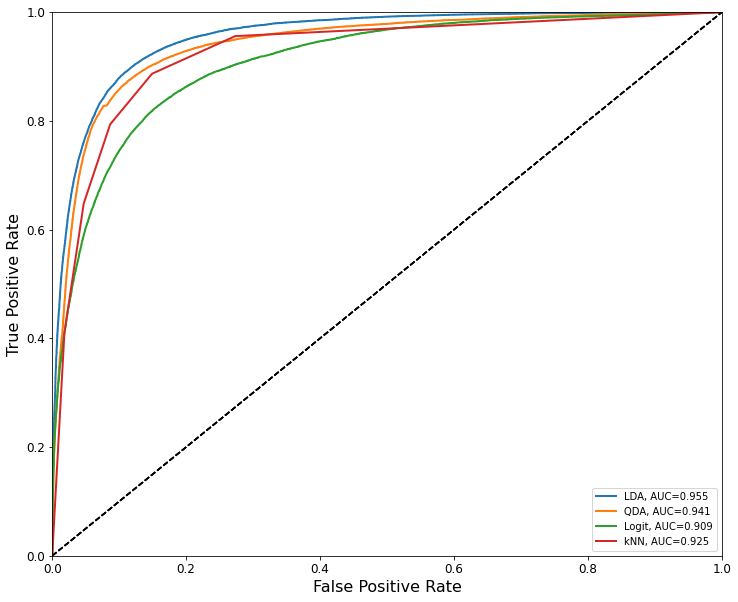

In [6]:
from sklearn.metrics import roc_auc_score
clfs = [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), LogisticRegression(), KNeighborsClassifier(), create_pnn(X_train.shape[1], 1, len(y_train))]
names = ["LDA", "QDA", "Logit", "kNN", "PNN"]

for clf, name in zip(clfs, names):
    if name == 'PNN':
        clf.fit(X_train, y_train, epochs=10, batch_size=128, verbose=0)
        print(f"{name}: {clf.evaluate(X_test, y_test)}")
    else:
        clf.fit(X_train, y_train)
        print(f"{name}: {clf.score(X_test, y_test)}")

fprs = []
tprs = []
aucs = []
for clf in clfs:
    if type(clf) is models.Sequential:
        # myAUC = AUC()
        # myAUC.update_state(y_test, clf.predict(X_test))
        # # yp = clf.predict(X_test).ravel()
        # fpr, tpr, thresh = np.array([0,0]), np.array([0,0]), 0#roc_curve(y_test, yp)
        # aucs.append(myAUC.result().numpy())
        
        pass
    else:
        try:
            fpr, tpr, thresh = roc_curve(y_test, clf.decision_function(X_test))
        except:
            fpr, tpr, thresh = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
        aucs.append(metrics.auc(fpr, tpr))
        
    fprs.append(fpr)
    tprs.append(tpr)

# for clf in clfs:
#     # try:
#     #     fpr, tpr, thresh = roc_curve(y_test, clf.decision_function(X_test))
#     # except:
#     fpr, tpr, thresh = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
#     fprs.append(fpr)
#     tprs.append(tpr)
#     aucs.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))


plt.figure(figsize=(12, 10))
for name, fpr, tpr, auc in zip(names, fprs, tprs, aucs):
    if name != 'PNN':
        plot_roc_curve(fpr, tpr, f"{name}, AUC={auc:.3f}")

plt.legend()
plt.show()

# Congressional Votes

In [7]:
votes = pd.read_csv('../datasets/house-votes-84.data', header=None)

enc = OrdinalEncoder()
votes = enc.fit_transform(votes)
votes = pd.DataFrame(votes)

votes.columns = ["Class","handicapped","water","budget","physician","el-salvador",\
    "religious","satellite","nicaraguan","missile","immigration", "cutback","education",\
    "sue","crime","duty-free","export"]

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(votes, votes["Class"]):
    votes_train = votes.loc[train_index].to_numpy()
    votes_test = votes.loc[test_index].to_numpy()

y_train = votes_train[:,0]
X_train = votes_train[:,1:]

y_test = votes_test[:,0]
X_test = votes_test[:,1:]

votes.describe()

,Class,handicapped,water,budget,physician,el-salvador,religious,satellite,nicaraguan,missile,immigration,cutback,education,sue,crime,duty-free,export
count,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.00000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000,435.000000
mean,0.386207,1.402299,1.337931,1.556322,1.381609,1.452874,1.60000,1.517241,1.521839,1.425287,1.480460,1.296552,1.321839,1.422989,1.531034,1.335632,1.379310
std,0.487440,0.544342,0.667418,0.545974,0.535928,0.563449,0.53967,0.561065,0.564998,0.588527,0.531462,0.553049,0.601347,0.599866,0.572671,0.593742,0.845718
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
50%,0.000000,1.000000,1.000000,2.000000,1.000000,1.000000,2.00000,2.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,2.000000,1.000000,2.000000
75%,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
max,1.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.00000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000


LDA: 0.9655172413793104
QDA: 0.9540229885057471
Logit: 0.9655172413793104
kNN: 0.9425287356321839
3/3 [==============================] - 0s 3ms/step - loss: 2.3796 - auc: 0.2089 - accuracy: 0.3908
PNN: [2.3795506954193115, 0.20893451571464539, 0.39080458879470825]


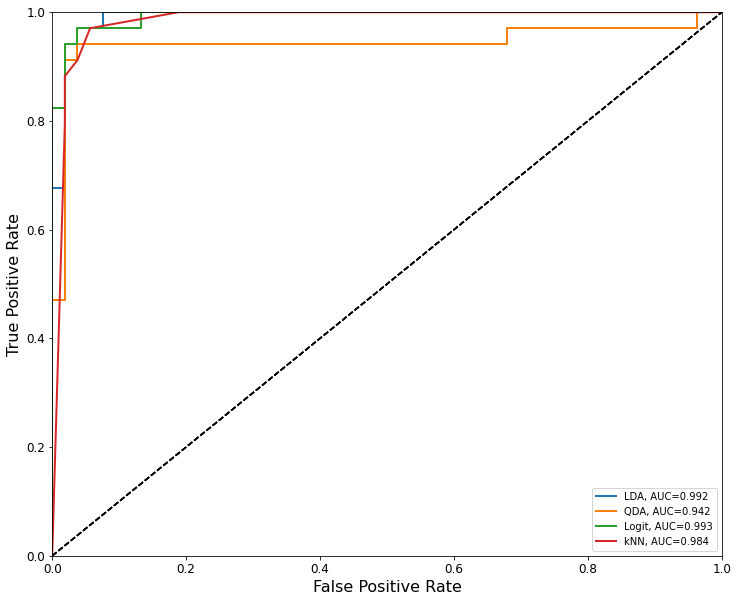

In [8]:
from sklearn.metrics import roc_auc_score

clfs = [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), LogisticRegression(), KNeighborsClassifier(), create_pnn(X_train.shape[1], 1, len(y_train))]
names = ["LDA", "QDA", "Logit", "kNN", "PNN"]

for clf, name in zip(clfs, names):
    if name == 'PNN':
        clf.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        print(f"{name}: {clf.evaluate(X_test, y_test)}")
    else:
        clf.fit(X_train, y_train)
        print(f"{name}: {clf.score(X_test, y_test)}")

fprs = []
tprs = []
aucs = []
for clf in clfs:
    if type(clf) is models.Sequential:
        # myAUC = AUC()
        # myAUC.update_state(y_test, clf.predict(X_test))
        # # yp = clf.predict(X_test).ravel()
        # fpr, tpr, thresh = np.array([0,0]), np.array([0,0]), 0#roc_curve(y_test, yp)
        # aucs.append(myAUC.result().numpy())
        
        pass
    else:
        try:
            fpr, tpr, thresh = roc_curve(y_test, clf.decision_function(X_test))
        except:
            fpr, tpr, thresh = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
        aucs.append(metrics.auc(fpr, tpr))
    fprs.append(fpr)
    tprs.append(tpr)
        
# for clf in clfs:
#     # try:
#     #     fpr, tpr, thresh = roc_curve(y_test, clf.decision_function(X_test))
#     # except:
#     fpr, tpr, thresh = roc_curve(y_test, clf.predict_proba(X_test)[:, 1])
#     fprs.append(fpr)
#     tprs.append(tpr)
#     aucs.append(roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1]))

# def plot_roc_curve(fpr, tpr, label=None):
#     plt.plot(fpr, tpr, linewidth=2, label=label)
#     plt.plot([0, 1], [0, 1], 'k--')
#     plt.axis([0, 1, 0, 1])
#     plt.xlabel('False Positive Rate', fontsize=16)
#     plt.ylabel('True Positive Rate', fontsize=16)


plt.figure(figsize=(12, 10))
for name, fpr, tpr, auc in zip(names, fprs, tprs, aucs):
    if name != 'PNN':
        plot_roc_curve(fpr, tpr, f"{name}, AUC={auc:.3f}")

plt.legend()
plt.show()

# Landsat Satellite


In [9]:
from sklearn.preprocessing import LabelBinarizer

train = pd.read_csv('../datasets/sat.trn', delimiter=' ', header=None)
test = pd.read_csv('../datasets/sat.tst', delimiter=' ', header=None)
enc = OrdinalEncoder()
y_train = train.to_numpy()[:,36]
X_train = train.to_numpy()[:,:36]

y_test = test.to_numpy()[:,36]
X_test = test.to_numpy()[:,:36]

lb = LabelBinarizer()
y_train = lb.fit_transform(y_train.reshape(-1,1))#.flatten()
y_test = lb.transform(y_test.reshape(-1,1))#.flatten()

train.describe()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
count,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,...,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000,4435.000000
mean,69.473957,83.855242,99.322886,82.555581,69.208794,83.499436,99.174521,82.480496,68.963472,83.131003,...,82.673957,69.033145,83.434273,99.183766,82.638106,68.797069,83.153326,99.061556,82.584442,3.650282
std,13.649635,22.725079,16.672166,18.695450,13.552423,22.811809,16.627583,18.714272,13.497858,22.813312,...,18.884322,13.533934,22.812090,16.741240,18.939820,13.437785,22.762684,16.660735,18.895513,2.217055
min,40.000000,27.000000,56.000000,33.000000,40.000000,27.000000,50.000000,29.000000,40.000000,27.000000,...,34.000000,39.000000,27.000000,50.000000,29.000000,40.000000,27.000000,50.000000,29.000000,1.000000
25%,60.000000,71.000000,85.000000,70.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,...,70.000000,60.000000,71.000000,85.000000,69.000000,60.000000,71.000000,85.000000,69.000000,2.000000
50%,68.000000,87.000000,101.000000,83.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,...,81.000000,68.000000,85.000000,101.000000,81.000000,67.000000,85.000000,100.000000,81.000000,3.000000
75%,80.000000,103.000000,113.000000,92.000000,80.000000,103.000000,113.000000,92.000000,79.000000,103.000000,...,92.000000,79.500000,103.000000,113.000000,92.000000,79.000000,103.000000,113.000000,92.000000,5.000000
max,104.000000,137.000000,140.000000,154.000000,102.000000,137.000000,145.000000,157.000000,104.000000,130.000000,...,154.000000,104.000000,128.000000,145.000000,157.000000,104.000000,130.000000,145.000000,157.000000,7.000000


LDA: 0.6735
QDA: 0.561


/home/psimmerl/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/psimmerl/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

Logit: 0.5215
kNN: 0.899
63/63 [==============================] - 1s 9ms/step - loss: 3.3483 - auc: 0.4722 - accuracy: 0.1940
PNN: [3.3483474254608154, 0.4721739888191223, 0.1940000057220459]


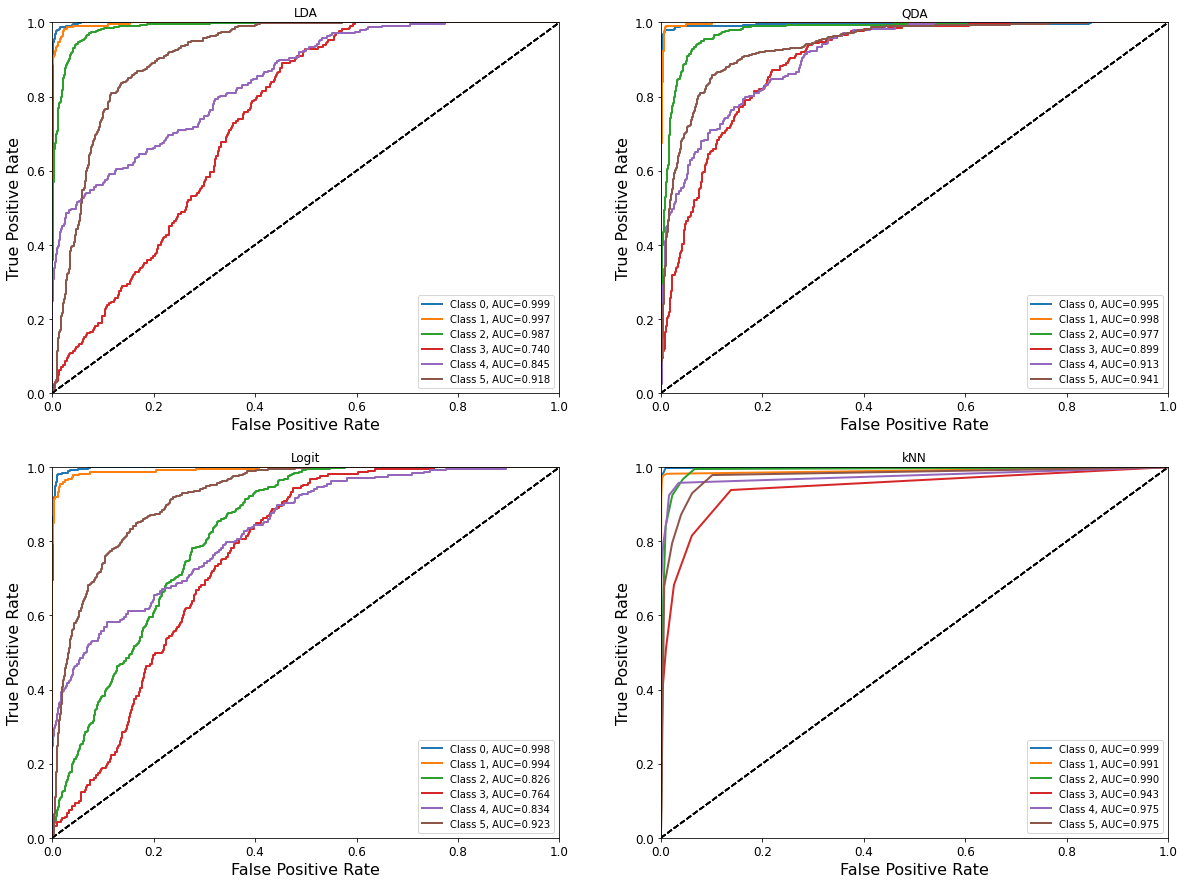

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.multiclass import OneVsRestClassifier

clfs = [OneVsRestClassifier(LinearDiscriminantAnalysis()), OneVsRestClassifier(QuadraticDiscriminantAnalysis()), 
        OneVsRestClassifier(LogisticRegression()), OneVsRestClassifier(KNeighborsClassifier()), create_pnn(X_train.shape[1], 6, len(y_train))]
# clfs = [LinearDiscriminantAnalysis(), QuadraticDiscriminantAnalysis(), LogisticRegression(), KNeighborsClassifier(), create_pnn(1, X_train.shape[1], len(y_train))]
names = ["LDA", "QDA", "Logit", "kNN", "PNN"]

for clf, name in zip(clfs, names):
    if name == 'PNN':
        clf.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)
        print(f"{name}: {clf.evaluate(X_test, y_test)}")
    else:
        clf.fit(X_train, y_train)
        print(f"{name}: {clf.score(X_test, y_test)}")

fprs = []
tprs = []
aucs = []
for clf in clfs:
    if type(clf) is models.Sequential:
        # myAUC = AUC()
        # myAUC.update_state(y_test, clf.predict(X_test))
        # # yp = clf.predict(X_test).ravel()
        # fpr, tpr, thresh = np.array([0,0]), np.array([0,0]), 0#roc_curve(y_test, yp)
        # aucs.append(myAUC.result().numpy())
        
        pass
    else:
        for i in range(6):
            try:
                fpr, tpr, thresh = roc_curve(y_test[:,i], clf.decision_function(X_test)[:,i])
            except:
                fpr, tpr, thresh = roc_curve(y_test[:,i], clf.predict_proba(X_test)[:, i])
            aucs.append(metrics.auc(fpr, tpr))
            fprs.append(fpr)
            tprs.append(tpr)

# for clf in clfs:
#     for i in range(6):
#         try:
#             fpr, tpr, thresh = roc_curve(y_test[:,i], clf.decision_function(X_test)[:,i])
#         except:
#             fpr, tpr, thresh = roc_curve(y_test[:, i], clf.predict_proba(X_test)[:, i])
#         fprs.append(fpr)
#         tprs.append(tpr)
#         aucs.append(roc_auc_score(y_test[:, i], clf.predict_proba(X_test)[:, i]))
#         # aucs.append(metrics.auc(fpr, tpr))
#         # print(aucs[-1])

def plot_roc_curve(fpr, tpr, ax, label=None):
    ax.plot(fpr, tpr, linewidth=2, label=label)
    ax.plot([0, 1], [0, 1], 'k--')
    ax.axis([0, 1, 0, 1])
    ax.set_xlabel('False Positive Rate', fontsize=16)
    ax.set_ylabel('True Positive Rate', fontsize=16)


f, axs = plt.subplots(2,2, figsize=(20,15))
for i in range(len(aucs)):
    ax = axs.flatten()[i//6]
    name = names[i//6]
    if name != 'PNN':
        fpr = fprs[i]
        tpr = tprs[i]
        auc = aucs[i]
        plot_roc_curve(fpr, tpr, ax, f"Class {i%6}, AUC={auc:.3f}")
        ax.set_title(name)
        ax.legend()